In [1]:
# Fit Forward, 12 day gap

In [2]:
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import random

In [3]:
maindir = '/results/forcing/rivers/observations/'
origdir = '/data/dlatorne/SOG-projects/SOG-forcing/ECget/'
def getdir(river_name):
    if river_name in ['Fraser', 'Englishman']:
        thedir = origdir
    else:
        thedir = maindir
    return (thedir)

In [4]:
def read_river(river_name, ps):
    thedir = getdir(river_name)
    river_flow = pd.read_csv(f'{thedir}/{river_name}_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    river_flow['date'] = pd.to_datetime(river_flow.drop(columns='flow'))
    river_flow.set_index('date', inplace=True)
    river_flow = river_flow.drop(columns=['year', 'month', 'day'])
    if ps == 'primary':
        river_flow = river_flow.rename(columns={'flow': 'Primary River Flow'})
    elif ps == 'secondary':
        river_flow = river_flow.rename(columns={'flow': 'Secondary River Flow'})
    return river_flow

In [5]:
def read_river_Theodosia(set_primary=False):
    if set_primary:
        nameit = 'Primary River Flow'
    else:
        nameit = 'Secondary River Flow'
    part1 = pd.read_csv(f'{maindir}/Theodosia_Scotty_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    part2 = pd.read_csv(f'{maindir}/Theodosia_Bypass_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    part3 = pd.read_csv(f'{maindir}/Theodosia_Diversion_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    for part in [part1, part2, part3]:
        part['date'] = pd.to_datetime(part.drop(columns='flow'))
        part.set_index('date', inplace=True)
        part.drop(columns=['year', 'month', 'day'], inplace=True)
    part1 = part1.rename(columns={'flow': 'Scotty'})
    part2 = part2.rename(columns={'flow': 'Bypass'})
    part3 = part3.rename(columns={'flow': 'Diversion'})
    theodosia = (part3.merge(part2, how='inner', on='date')).merge(part1, how='inner', on='date')
    theodosia[nameit] = theodosia['Scotty'] + theodosia['Diversion'] - theodosia['Bypass']
    part3['FlowFromDiversion'] = part3.Diversion * theodosia_from_diversion_only
    theodosia = theodosia.merge(part3, how='outer', on='date', sort=True)
    theodosia[nameit] = theodosia[nameit].fillna(
        theodosia['FlowFromDiversion'])
    return theodosia

In [6]:
matching_dictionary = {'Englishman': 'Salmon_Sayward',
                      'Theodosia': 'Clowhom_ClowhomLake',
                      'RobertsCreek': 'Englishman',
                      'Salmon_Sayward': 'Englishman',
                      'Squamish_Brackendale': 'Homathko_Mouth',
                      'SanJuan_PortRenfrew': 'Englishman',
                      'Nisqually_McKenna': 'Snohomish_Monroe',
                      'Snohomish_Monroe': 'Skagit_MountVernon',
                      'Skagit_MountVernon': 'Snohomish_Monroe',
                      'Homathko_Mouth': 'Squamish_Brackendale',
                      'Nicomekl_Langley': 'RobertsCreek',
                      'Greenwater_Greenwater': 'Snohomish_Monroe',
                      'Clowhom_ClowhomLake': 'Theodosia_Diversion'}
backup_dictionary = {'SanJuan_PortRenfrew': 'RobertsCreek',
                    'Theodosia': 'Englishman'}

theodosia_from_diversion_only = 1.429 # see TheodosiaWOScotty

In [7]:
gap_length = 12

In [8]:
def estimate(primary_river, spoint, point, gap_length, ax, fittedbad, fittype, nobad, doplots=True):
    goback = 7
    bad = False
    fitlength = np.array([7, 14, 21, 28])
    ratio = np.zeros(len(fitlength))
    fitted = np.zeros(len(fitlength))
    persist = np.zeros((goback))
    linear = np.zeros((goback-1))
    cubic = np.zeros((goback-2))
    
    if len(primary_river.iloc[spoint-8:spoint]) != 8:
        print (len(primary_river.iloc[spoint-8:spoint]), primary_river.iloc[spoint])
        nobad = nobad + 1
        allbad = True
    else:
        allbad = False
        for ii in range(1, 8):
            jj = ii + gap_length - 1        
            persist[ii-1] = primary_river.iloc[spoint-ii:spoint].mean()
            if ii > 1:
                b, m = polyfit(range(ii), primary_river.iloc[spoint-ii:spoint].values, 1)
                linear[ii-2] = b + m * jj
            if ii > 2:
                b, m, c = polyfit(range(ii), primary_river.iloc[spoint-ii:spoint].values, 2)
                cubic[ii-3] = b + m * jj + c * jj**2

        if fittype == 'fit':
            useriver = matching_dictionary[river]
        elif fittype == 'backup':
            useriver = backup_dictionary[river]
        firstchoice = read_river(useriver, 'primary')
        for jj, length in enumerate(fitlength):
            for ii in range(length):
                denom = firstchoice[firstchoice.index == primary_river.index[spoint-ii]].values
                if len(denom) == 1:
                    ratio[jj] = ratio[jj] + (primary_river.iloc[spoint-ii].values /
                                firstchoice[firstchoice.index == primary_river.index[spoint-ii]].values)
                else:
                    bad = True
            if not bad:
                numer = firstchoice[firstchoice.index == primary_river.index[point]].values
                if len(numer) != 1:
                    print ('Numer catch')
                    bad = True
                else:
                    fitted[jj] = ratio[jj]/length * firstchoice[firstchoice.index == primary_river.index[point]].values
        if bad:
            fittedbad = fittedbad + 1
        if doplots:
            ax.plot(persist)
            ax.plot(range(1, 7), linear)
            ax.plot(range(2, 7), cubic)
            if not bad:
                ax.plot(fitted)
            ax.plot(primary_river.iloc[spoint-7:spoint].values, 'o')
            ax.plot(7, primary_river.iloc[spoint].values, 'x')
            ax.plot(7+gap_length, primary_river.iloc[point].values, 's')
            ax.grid()
    return (persist, linear, cubic, fitted, bad, fittedbad, allbad, nobad)

In [9]:
def pmhalf(test, value):
    bads = np.zeros(len(test), dtype='bool')
    for ii, tt in enumerate(test):
        if tt/value < 0.5 or tt/value > 2:
            bads[ii] = True
    return bads

In [10]:
def inbounds(test, maximum, minimum):
    bads = np.zeros(len(test), dtype='bool')
    for ii, tt in enumerate(test):
        if tt < minimum or tt > maximum:
            bads[ii] = True
    return bads

In [11]:
def docheck(primary_river, point, persist, linear, cubic, fitted, badfit, ax, doplots=True):
    maximum = primary_river['Primary River Flow'].max()
    minimum = primary_river['Primary River Flow'].min()
    value = primary_river.iloc[point].values
    goodness_persist = np.abs(persist - value)
    goodness_linear = np.abs(linear - value)
    goodness_cubic = np.abs(cubic - value)
    if not badfit:
        goodness_fit = np.abs(fitted - value)
        pmfitted = pmhalf(fitted, value)
        ibfitted = inbounds(fitted, maximum, minimum)
    else:
        goodness_fit = np.zeros((4))
        pmfitted = np.zeros((4))
        ibfitted = np.zeros((4))
    if doplots:
        ax.plot(goodness_persist, 'o')
        ax.plot(goodness_linear, 'o')
        ax.plot(goodness_cubic, 'o')
        if not badfit:
            ax.plot(goodness_fit, 'o')
        ax.grid()
    return (np.concatenate((goodness_persist, goodness_linear, goodness_cubic, goodness_fit)), 
            np.concatenate((pmhalf(persist, value), pmhalf(linear, value), pmhalf(cubic, value), pmfitted)),
            np.concatenate((inbounds(persist, maximum, minimum), inbounds(linear, maximum, minimum), 
                            inbounds(cubic, maximum, minimum), ibfitted)))

In [12]:
def doone(primary_river, gap_length, accumulateG, accumulateC, accumulateB, fittedbad, fittype, nobad, doplots=True):

    point = random.randrange(len(primary_river.index))
    spoint = point - gap_length + 1
    
    if doplots:
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))

        primary_river.iloc[point-10:point+1].plot(ax=axs[0], marker='s')
    else:
        axs = [0, 1, 2]

    (persist, linear, cubic, fitted, badfit, fittedbad, allbad, nobad) = estimate(
        primary_river, spoint, point, gap_length, axs[1], fittedbad, fittype, nobad, doplots)

    if not allbad:
        GG, CC, BB = docheck(primary_river, point, persist, linear, cubic, fitted, badfit, axs[2], doplots)
        accumulateG += GG
        accumulateC += CC
        accumulateB += BB
    
    
    return accumulateG, accumulateC, accumulateB, fittedbad, nobad

In [13]:
print (gap_length)

12


In [14]:
river = 'Homathko_Mouth'
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
nobad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad, nobad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', nobad, doplots=False)
    
print ("realized", number_trys - nobad)

number_good = (number_trys - nobad) * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

Numer catch
Numer catch
Numer catch
Numer catch
Numer catch
Numer catch
realized 1000
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  959.  959.  959.  959.] [ 106.398808    107.13139478  106.94418135  106.53481396  106.92049547
  107.53633211  107.74341394  410.58040748  343.7700528   312.33132402
  302.90840114  283.1714053   255.43797896 3093.63688558 2178.6075646
 1746.03014021 1406.13956362 1202.55699789   67.3105291    71.51149256
   75.77960913   79.44650106] [0.162      0.165      0.168      0.163      0.171      0.174
 0.172      0.588      0.587      0.556      0.528      0.521
 0.504      0.843      0.817      0.806      0.796      0.79
 0.06569343 0.06360792 0.06465068 0.06777894] [0.         0.         0.         0.         0.         0.
 0.         0.275      0.259      0.233      0.228      0.207
 0.189      0.525      0.497      0.484      0.463      0.439
 0.00521376 0.00208551 0.00208551 0.00417101]


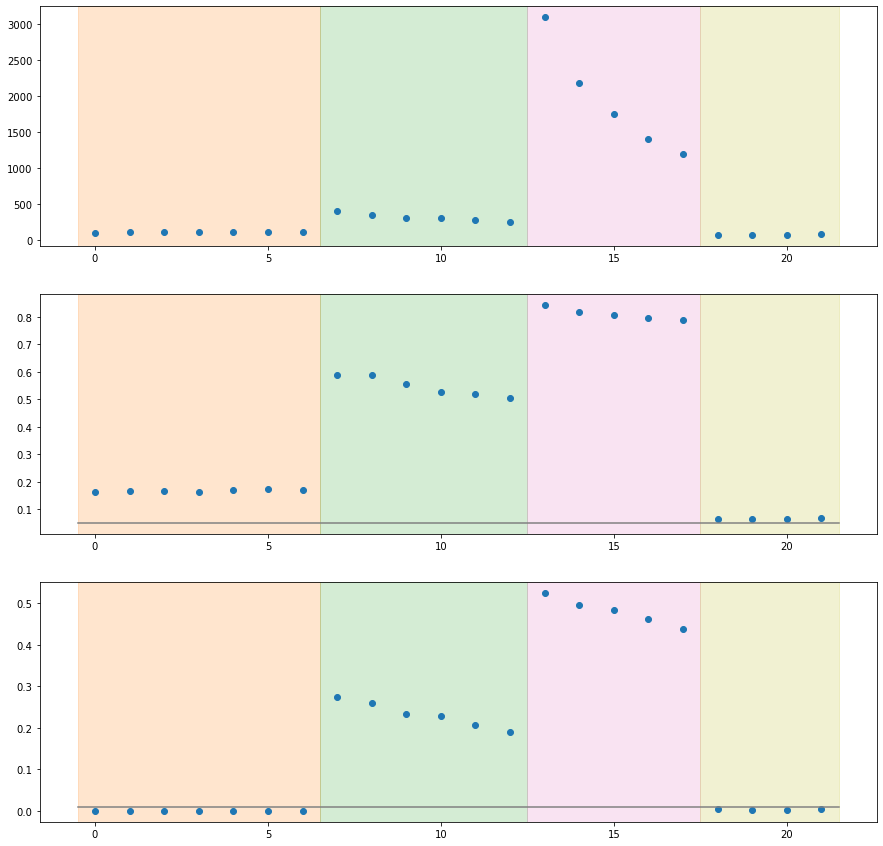

In [15]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [16]:
print (gap_length)

12


In [17]:
river = 'Skagit_MountVernon'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
nobad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad, nobad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', nobad, doplots=False)
    
print ("realized", number_trys - nobad)

number_good = (number_trys - nobad) * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


0 Primary River Flow    300.1581
Name: 1970-01-03 00:00:00, dtype: float64
realized 999
[999. 999. 999. 999. 999. 999. 999. 999. 999. 999. 999. 999. 999. 999.
 999. 999. 999. 999. 996. 996. 996. 996.] [ 177.54747167  176.82948894  175.89324811  176.324377    175.4014593
  175.7288459   176.15013539  726.46878218  600.8111856   523.07916185
  480.65815504  445.43154373  413.50867815 5450.09802563 3630.43325341
 2857.19404034 2264.18862227 1921.09072432  167.79922274  169.36097324
  173.38871275  179.93372729] [0.12112112 0.11511512 0.10810811 0.10510511 0.1031031  0.10610611
 0.1021021  0.65065065 0.59459459 0.54154154 0.51251251 0.47147147
 0.44144144 0.91191191 0.86186186 0.84984985 0.81981982 0.81881882
 0.06827309 0.07429719 0.0753012  0.08032129] [0.         0.         0.         0.         0.         0.
 0.         0.36036036 0.28228228 0.26026026 0.22722723 0.21421421
 0.17817818 0.64164164 0.56256256 0.51451451 0.48648649 0.44644645
 0.00401606 0.         0.         0.00200803]


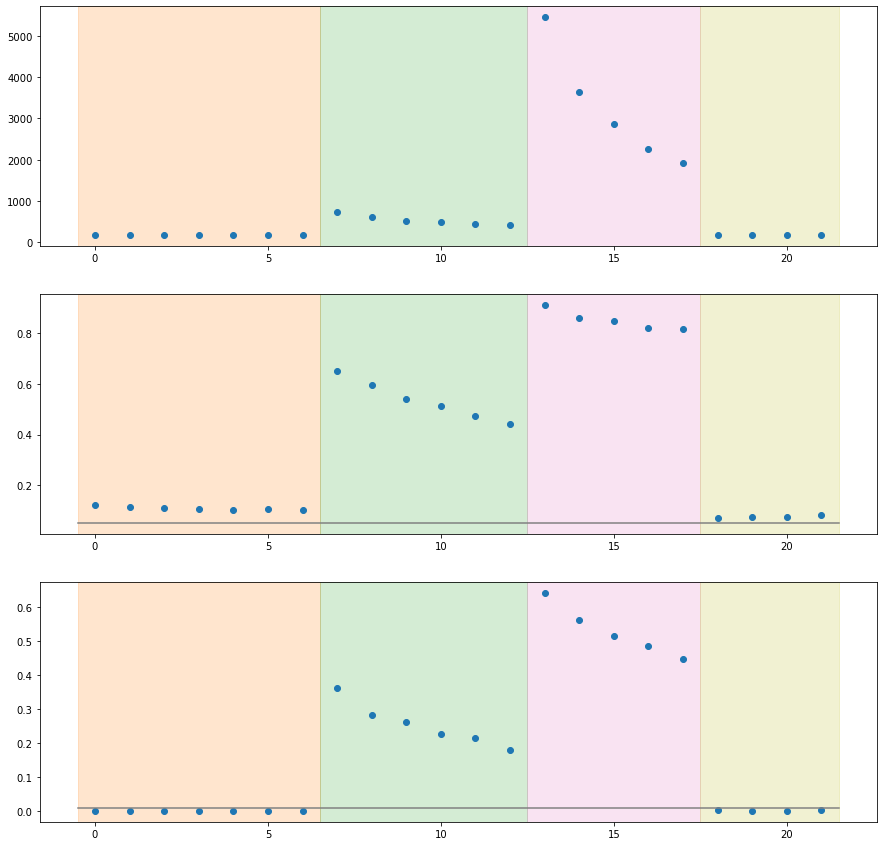

In [18]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');